## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


In [ ]:
# для открытия и чтения файлов с данным c Google.Drive через Google.Colab

from google.colab import drive
drive.mount('/content/drive')
train_file = '/content/drive/MyDrive/Data_Science/Project_5_Задача_регрессии/train.csv'
holiday_data_file = '/content/drive/MyDrive/Data_Science/Project_5_Задача_регрессии/holiday_data.csv'
osrm_data_train_file = '/content/drive/MyDrive/Data_Science/Project_5_Задача_регрессии/osrm_data_train.csv'
weather_data_file = '/content/drive/MyDrive/Data_Science/Project_5_Задача_регрессии/weather_data.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn.feature_selection import  SelectKBest,f_regression

import warnings
warnings.filterwarnings("ignore")

!pip install optuna
import optuna

Прочитаем наш файл с исходными данными:

In [ ]:
taxi_data = pd.read_csv(train_file)
print(f'Train data shape: {taxi_data.shape}')
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

In [ ]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [ ]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.


In [ ]:
round(taxi_data.describe())

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.0,1458644.0,1458644.0,1458644.0,1458644.0,1458644.0,1458644.0
mean,2.0,2.0,-74.0,41.0,-74.0,41.0,959.0
std,0.0,1.0,0.0,0.0,0.0,0.0,5237.0
min,1.0,0.0,-122.0,34.0,-122.0,32.0,1.0
25%,1.0,1.0,-74.0,41.0,-74.0,41.0,397.0
50%,2.0,1.0,-74.0,41.0,-74.0,41.0,662.0
75%,2.0,2.0,-74.0,41.0,-74.0,41.0,1075.0
max,2.0,9.0,-61.0,52.0,-61.0,44.0,3526282.0


In [ ]:
print(f'Уникальных таксопарков: {taxi_data.vendor_id.nunique()}.')
print(f'Максимальное количество пассажиров: {taxi_data.passenger_count.max()}.')
print(f'Медианная длительность поездки: {int(taxi_data.trip_duration.median())} секунд.')
print(f'Средняя длительность поездки: {int(taxi_data.trip_duration.mean())} секунд.')
print(f'Мининальная длительность поездки: {int(taxi_data.trip_duration.min())} секунд.')
print(f'Максимальная длительность поездки: {int(taxi_data.trip_duration.max())} секунд.')

Уникальных таксопарков: 2.
Максимальное количество пассажиров: 9.
Медианная длительность поездки: 662 секунд.
Средняя длительность поездки: 959 секунд.
Мининальная длительность поездки: 1 секунд.
Максимальная длительность поездки: 3526282 секунд.


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

In [ ]:
def add_datetime_features(dataframe, feature):
  dataframe['pickup_date'] = dataframe[feature].dt.date
  dataframe['pickup_hour'] = dataframe[feature].dt.hour
  dataframe['pickup_day_of_week'] = dataframe[feature].dt.dayofweek
  return dataframe

taxi_data = add_datetime_features(taxi_data, 'pickup_datetime')

print(f'{round(taxi_data.id.nunique() / taxi_data.pickup_date.nunique(),0)} поездок в среднем совершается в день.')

8015.0 поездок в среднем совершается в день.


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).



In [ ]:
holiday_data = pd.read_csv(holiday_data_file, sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date'],format='%Y-%m-%d').dt.date

def add_holiday_features(dataframe, holiday_data):
  holiday_list = list(holiday_data.date)
  dataframe['pickup_holiday'] = dataframe['pickup_date'].apply(lambda date: 1 if date in holiday_list
                                                               else 0)
  return dataframe

taxi_data = add_holiday_features(taxi_data, holiday_data)

holiday_trip_median = int(taxi_data[taxi_data.pickup_holiday == 1].trip_duration.median())
print(f'{holiday_trip_median} секунд медианная длительность поездки на такси в праздничные дни.')

585 секунд медианная длительность поездки на такси в праздничные дни.


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [ ]:
osrm_data = pd.read_csv(osrm_data_train_file)

In [ ]:
def add_osrm_features(dataframe, osrm_data):
  osrm_data.drop(['starting_street','end_street','street_for_each_step',
  'distance_per_step','travel_time_per_step','step_maneuvers',
  'step_direction','step_location_list'], axis=1, inplace=True)
  dataframe = dataframe.merge(
                            osrm_data,
                            left_on='id',
                            right_on='id',
                            how='left')
  return dataframe

taxi_data = add_osrm_features(taxi_data, osrm_data)
delta_trip_duration = round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median(), 0)
print(f'Разница между медианной длительностью поездки в данных и медианной длительностью поездки,\n полученной из OSRM составила {delta_trip_duration} секунды.')

Разница между медианной длительностью поездки в данных и медианной длительностью поездки,
 полученной из OSRM составила 372.0 секунды.


In [ ]:
# изучим пропуски в новых признаках
taxi_data[(taxi_data.total_distance.isna() == True)|
          (taxi_data.total_travel_time.isna() == True)|
          (taxi_data.number_of_steps.isna() == True)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
1133561,id3008062,2,2016-06-23 19:04:09,2016-06-23 19:04:35,1,-73.787537,40.64241,-73.787811,40.642109,N,26,2016-06-23,19,3,0,NaN,NaN,NaN


### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [ ]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [ ]:
def add_geographical_features(dataframe):
  dataframe['haversine_distance'] = get_haversine_distance(dataframe['pickup_latitude'],
                                                           dataframe['pickup_longitude'],
                                                           dataframe['dropoff_latitude'],
                                                           dataframe['dropoff_longitude'])
  dataframe['direction'] = get_angle_direction(dataframe['pickup_latitude'],
                                               dataframe['pickup_longitude'],
                                               dataframe['dropoff_latitude'],
                                               dataframe['dropoff_longitude'])
  return dataframe

taxi_data = add_geographical_features(taxi_data)

print(f'Mедианное расстояние xаверсина {round(taxi_data.haversine_distance.median(),2)} км.')

Mедианное расстояние xаверсина 2.09 км.


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [ ]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(dataframe, model=kmeans):
  coords = np.hstack((dataframe[['pickup_latitude', 'pickup_longitude']],
                      dataframe[['dropoff_latitude', 'dropoff_longitude']]))
  dataframe['geo_cluster'] = kmeans.predict(coords)
  return dataframe

taxi_data = add_cluster_features(taxi_data)
print(f'В наименьшем по размеру географическом кластере {taxi_data.geo_cluster.value_counts().min()} поездки.')

В наименьшем по размеру географическом кластере 2 поездки.


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [ ]:
weather_data = pd.read_csv(weather_data_file)
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')
weather_data['pickup_date'] = weather_data['time'].dt.date
weather_data['pickup_hour'] = weather_data['time'].dt.hour
weather_data.drop(['time','humidity','windchill','heat index','pressure','dew Point',
                   'wind dir', 'gust speed', 'conditions', 'date','hour'], axis=1, inplace=True)

In [ ]:
def add_weather_features(dataframe, weather_data):
  dataframe = dataframe.merge(
      weather_data,
      on=['pickup_date','pickup_hour'],
      how='left')
  return dataframe

taxi_data = add_weather_features(taxi_data, weather_data)

snow_trip = taxi_data.events.value_counts().loc['Snow']
print(f'{snow_trip} поездок было совершено в снежную погоду.')

13126 поездок было совершено в снежную погоду.


In [ ]:
print(round(taxi_data.events.isna().sum()/taxi_data.shape[0]*100, 2),'% пропусков в столбцах с погодными условиями.')

0.82 % пропусков в столбцах с погодными условиями.


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.



In [ ]:
def fill_null_weather_data(dataframe):

  dataframe['events'].fillna('None', inplace=True)

  empty_cols = ['temperature', 'visibility', 'wind speed', 'precip',
                'total_distance','total_travel_time','number_of_steps']

  dataframe[empty_cols] = dataframe[empty_cols].fillna(
    dataframe.groupby('pickup_date')[empty_cols].transform('median')
    )

  return dataframe

taxi_data = fill_null_weather_data(taxi_data)

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


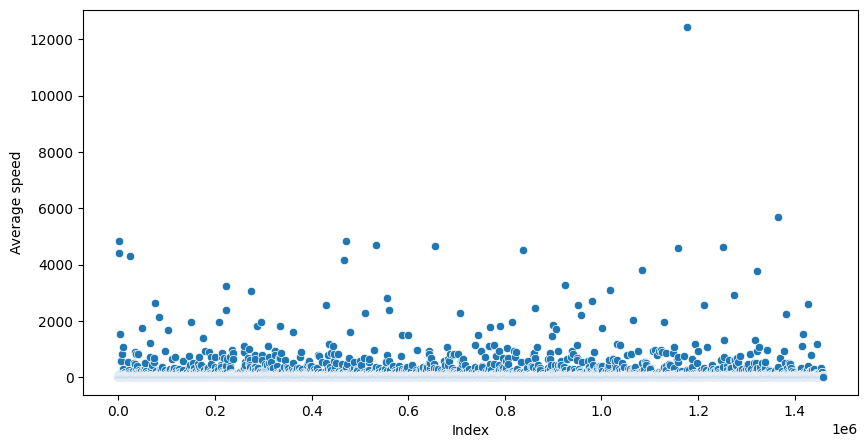

In [ ]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.


In [ ]:
max_trip_dur = 24 * 3600
taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
drop_lst = list(taxi_data[(taxi_data.avg_speed > 300) | (taxi_data.trip_duration > max_trip_dur)].index)
taxi_data.drop(index=drop_lst, inplace=True)

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [ ]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

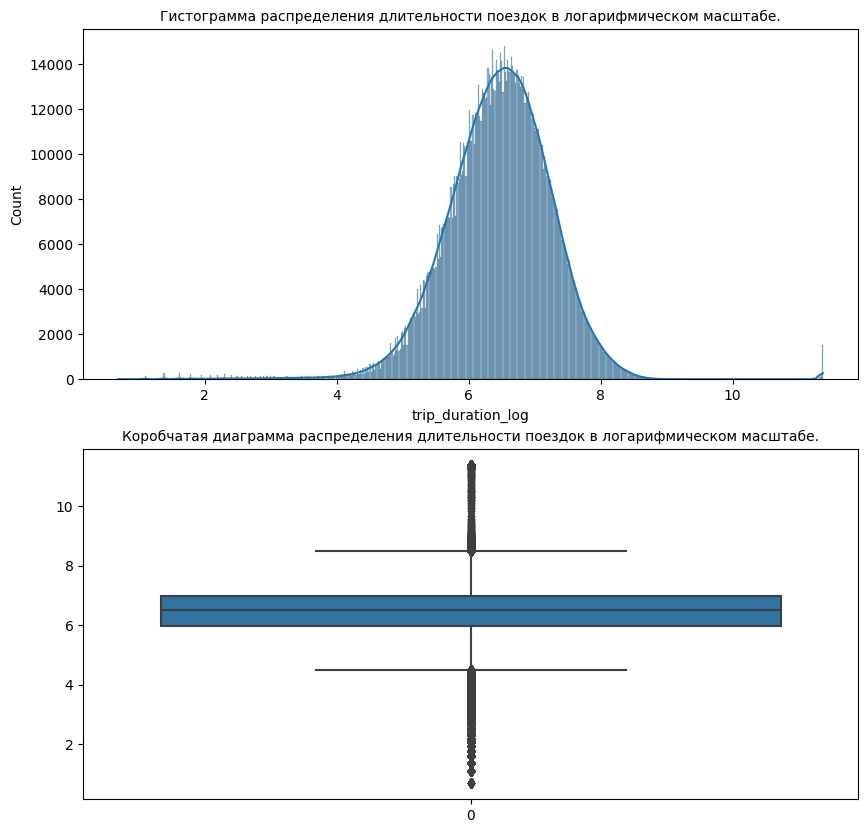

In [ ]:
# ваш код здесь
fig, axe = plt.subplots(2, 1, figsize=(10, 10))

axe[0].set_title('Гистограмма распределения длительности поездок в логарифмическом масштабе.',
                 fontsize=10)
sns.histplot(taxi_data['trip_duration_log'],
             kde=True,
             ax=axe[0])

axe[1].set_title('Коробчатая диаграмма распределения длительности поездок в логарифмическом масштабе.',
                 fontsize=10)
sns.boxplot(taxi_data['trip_duration_log'],
            ax=axe[1])
plt.show()

In [ ]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

alpha = 0.05

res = stats.normaltest(taxi_data['trip_duration_log'])
print(f'p-value={round(res.pvalue, 3)}')

if res.pvalue > alpha/2:
	print(H0)
else:
	print(Ha)

p-value=0.0
Данные не распределены нормально (мы отвергаем H0)


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

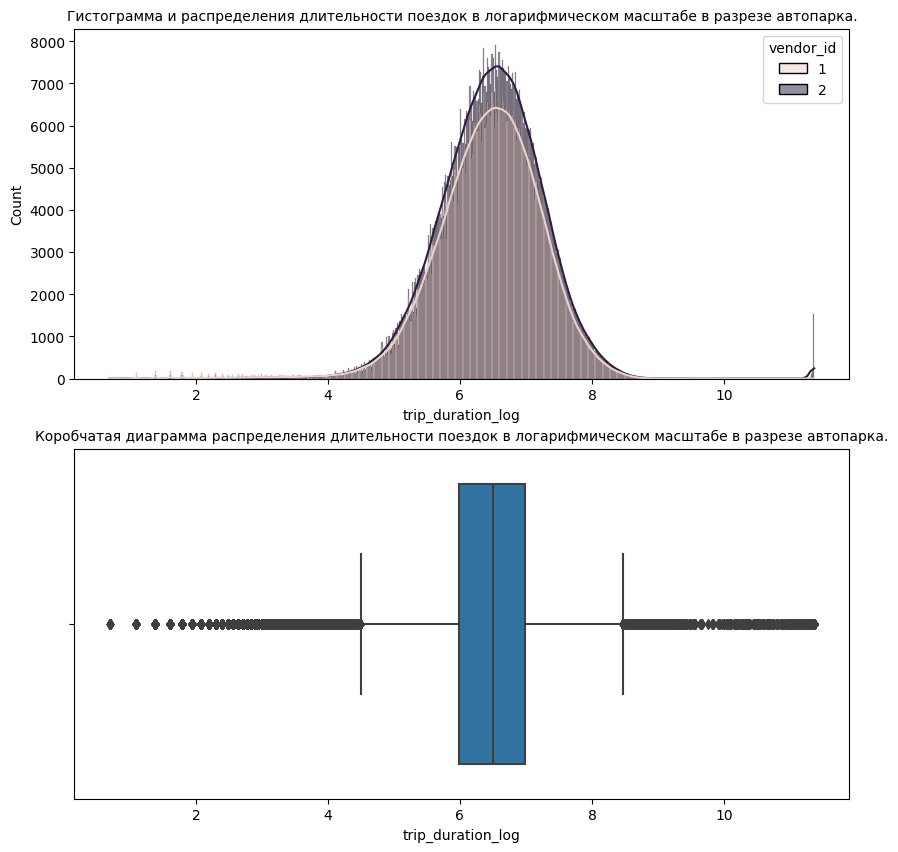

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title('Гистограмма и распределения длительности поездок в логарифмическом масштабе в разрезе автопарка.',
                 fontsize=10)
sns.histplot(taxi_data, x='trip_duration_log', hue='vendor_id', kde=True, ax=axes[0])

axes[1].set_title('Коробчатая диаграмма распределения длительности поездок в логарифмическом масштабе в разрезе автопарка.',
                  fontsize=10)
sns.boxplot(taxi_data, x='trip_duration_log', hue='vendor_id', ax=axes[1])
plt.show()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

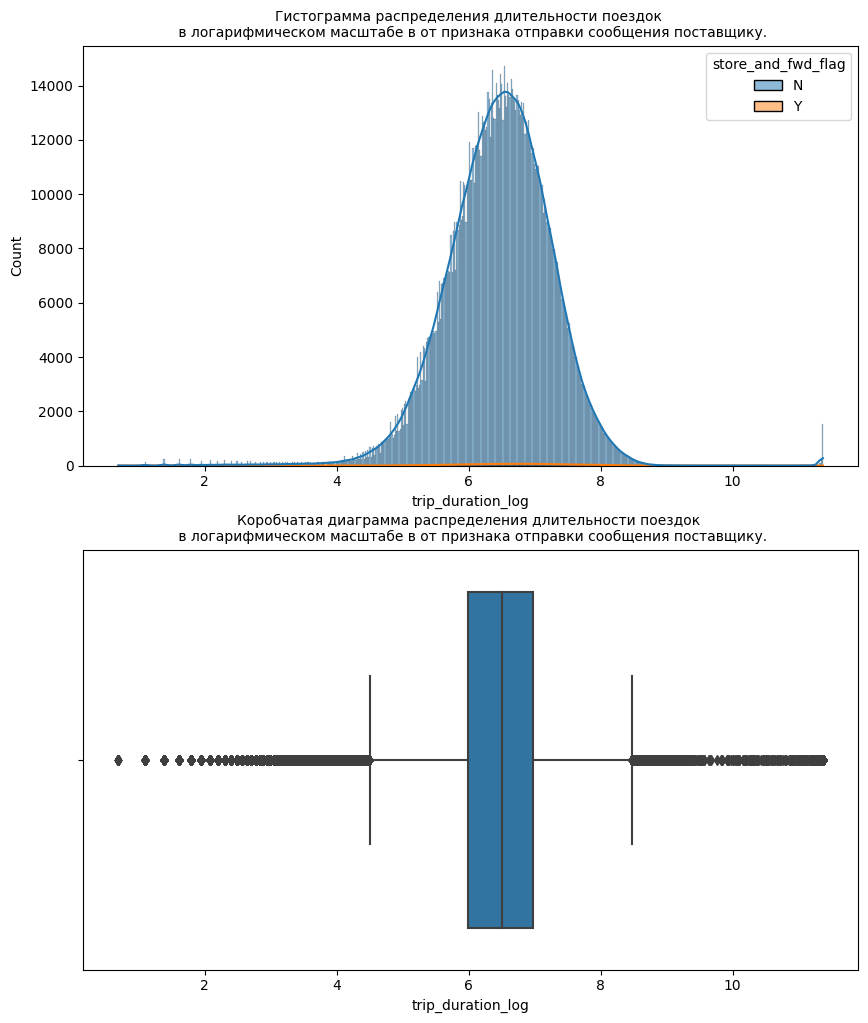

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

axes[0].set_title('Гистограмма распределения длительности поездок \n в логарифмическом масштабе в от признака отправки сообщения поставщику.',
                 fontsize=10)
sns.histplot(taxi_data,
             x='trip_duration_log',
             hue='store_and_fwd_flag',
             kde=True,
             ax=axes[0])

axes[1].set_title('Коробчатая диаграмма распределения длительности поездок \n в логарифмическом масштабе в от признака отправки сообщения поставщику.',
                 fontsize=10)
sns.boxplot(taxi_data,
            x='trip_duration_log',
            hue='store_and_fwd_flag',
            ax=axes[1])
plt.show()

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

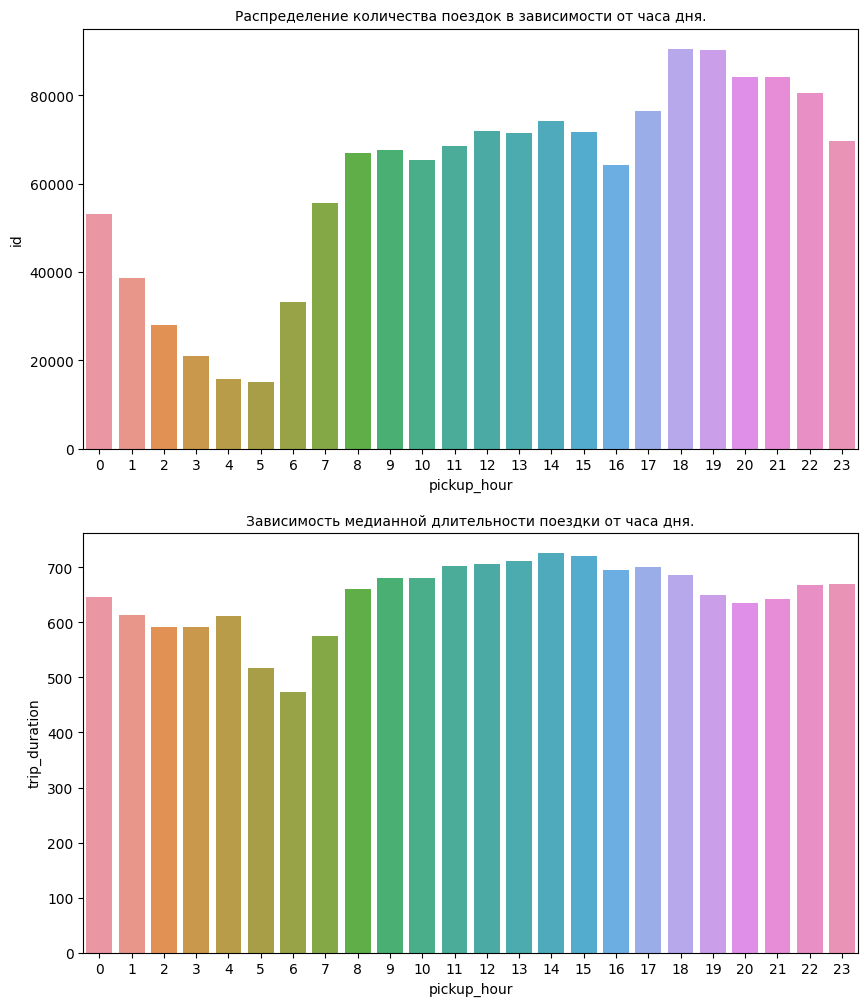

In [ ]:
count_data = taxi_data.groupby('pickup_hour', as_index=False)['id'].count()
median_trip = taxi_data.groupby('pickup_hour', as_index=False)['trip_duration'].median()

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

axes[0].set_title('Распределение количества поездок в зависимости от часа дня.',
                 fontsize=10)
sns.barplot(count_data,
            x='pickup_hour',
            y = 'id',
            ax=axes[0])

axes[1].set_title('Зависимость медианной длительности поездки от часа дня.',
                 fontsize=10)
sns.barplot(median_trip,
            x='pickup_hour',
            y='trip_duration',
            ax=axes[1])

plt.show()

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.


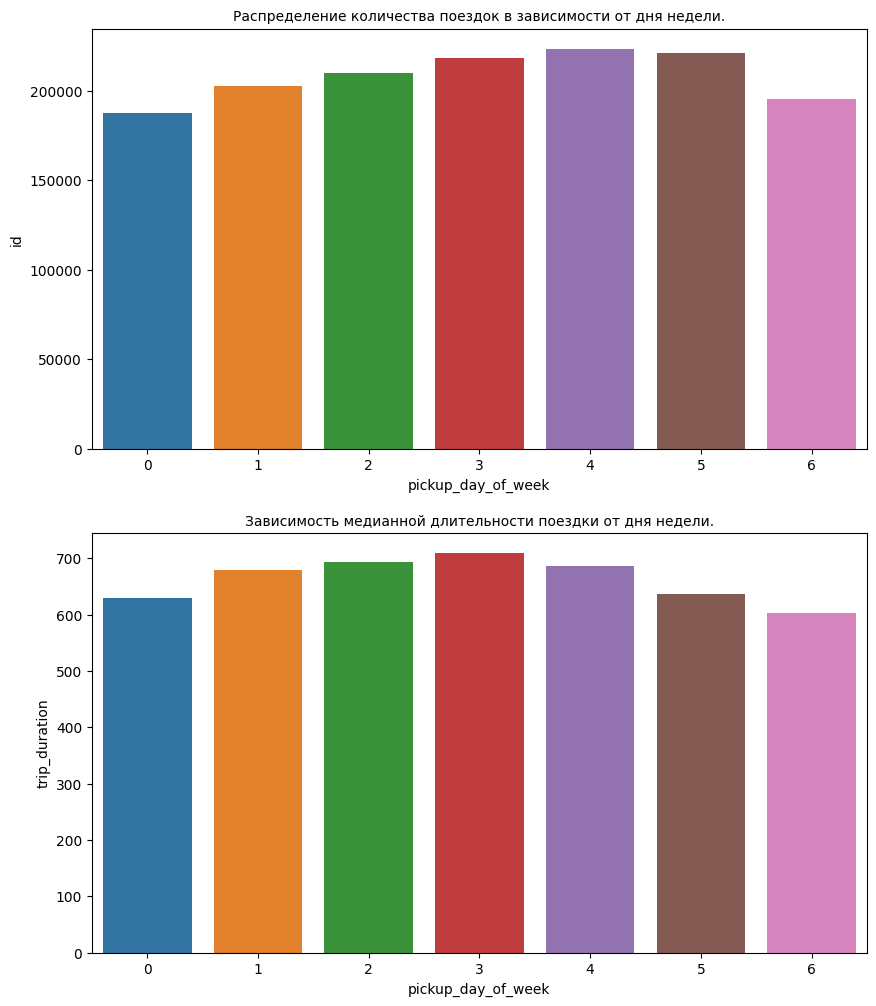

In [ ]:
day_data = taxi_data.groupby('pickup_day_of_week', as_index=False)['id'].count()
median_trip = taxi_data.groupby('pickup_day_of_week', as_index=False)['trip_duration'].median()

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

axes[0].set_title('Распределение количества поездок в зависимости от дня недели.',
                 fontsize=10)
sns.barplot(day_data,
            x='pickup_day_of_week',
            y = 'id',
            ax=axes[0])

axes[1].set_title('Зависимость медианной длительности поездки от дня недели.',
                 fontsize=10)
sns.barplot(median_trip,
            x='pickup_day_of_week',
            y='trip_duration',
            ax=axes[1])

plt.show()

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

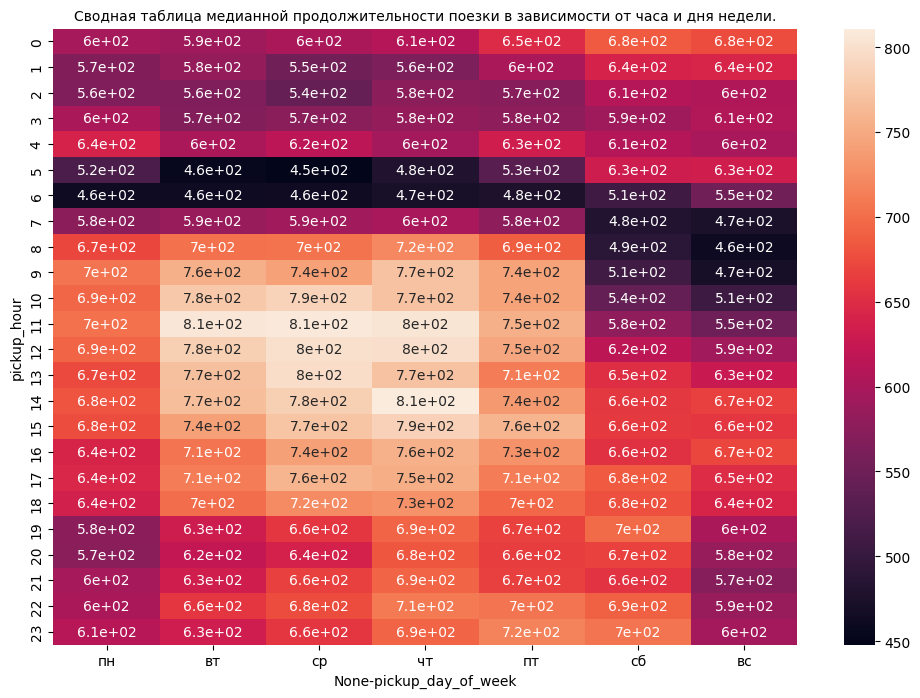

In [ ]:
table = pd.pivot_table(taxi_data,
                       values=['trip_duration'],
                       index=['pickup_hour'],
                       columns=['pickup_day_of_week'],
                       aggfunc='median')

fig = plt.figure(figsize=(12, 8))
plt.title('Сводная таблица медианной продолжительности поезки в зависимости от часа и дня недели.',
                 fontsize=10)
sns.heatmap(table,
            annot=True,
            linecolor='orange',
            xticklabels=['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'],
            yticklabels=[i for i in range(0,24)])
plt.show()

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.  


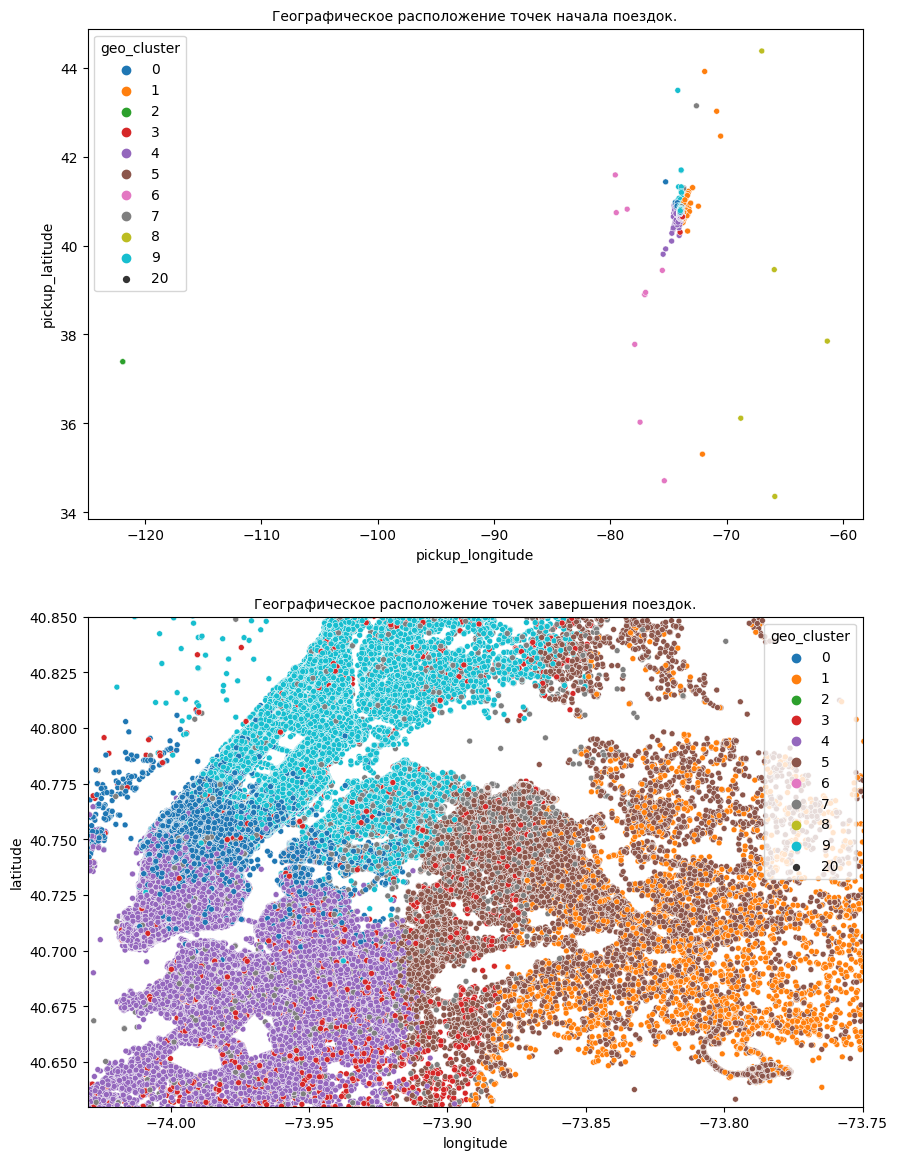

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
# ваш код здесь

fig, axes = plt.subplots(2, 1, figsize=(10, 14))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.legend(bbox_to_anchor=(1, 0.6))

axes[0].set_title('Географическое расположение точек начала поездок.',
                 fontsize=10)
sns.scatterplot(data=taxi_data,
                x='pickup_longitude',
                y='pickup_latitude',
                palette="tab10",
                hue='geo_cluster',
                size=20,
                markers=True,
                ax=axes[0])

axes[1].set_title('Географическое расположение точек завершения поездок.',
                 fontsize=10)
sns.scatterplot(data=taxi_data,
                x='dropoff_longitude',
                y='dropoff_latitude',
                palette="tab10",
                hue='geo_cluster',
                size=20,
                markers=True,
                ax=axes[1])
plt.show()

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [ ]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'avg_speed', 'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [ ]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,avg_speed,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,15.896176,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,13.646335,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,18.747119,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,14.932028,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,13.364690,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [ ]:
train_data = train_data.drop(['id','dropoff_datetime','avg_speed'],axis=1)
train_data.shape

(1458233, 25)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.



In [ ]:
# ваш код здесь
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.



In [ ]:
one_hot_encoder = preprocessing.OneHotEncoder(drop='first')
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change])
data_onehot = data_onehot.toarray()
column_names = one_hot_encoder.get_feature_names_out()
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
data_onehot.shape

(1458233, 18)

Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [ ]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [ ]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [ ]:
SKBest = SelectKBest(f_regression, k=25)
SKBest.fit(X_train, y_train_log)
best_features = SKBest.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]
print(f'Наиболее значимые признаки:\n{best_features}')

Наиболее значимые признаки:
['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_1'
 'pickup_day_of_week_2' 'pickup_day_of_week_3' 'pickup_day_of_week_4'
 'pickup_day_of_week_5' 'pickup_day_of_week_6' 'geo_cluster_1'
 'geo_cluster_3' 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [ ]:
# ваш код здесь
X_train_cols = X_train.columns
X_valid_cols = X_valid.columns

scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

X_train = pd.DataFrame(X_train, columns=X_train_cols)
X_valid = pd.DataFrame(X_valid, columns=X_valid_cols)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train_log)
y_pred_train = lr.predict(X_train)
y_pred_valid = lr.predict(X_valid)
print('RMSLE on X_train: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_pred_train))))
print('RMSLE on X_valid: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log.values, y_pred_valid))))

RMSLE on X_train: 0.54
RMSLE on X_valid: 0.54


### Задание 5.2.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.



In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state = 42)
tree.fit(X_train, y_train_log)
y_pred_train = tree.predict(X_train)
y_pred_valid = tree.predict(X_valid)
print('RMSLE on X_train_poly: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))))
print('RMSLE on X_valid_poly: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))))

RMSLE on X_train_poly: 0.00
RMSLE on X_valid_poly: 0.57


### Задание 5.3.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.


In [ ]:
def optuna_rf(trial):
  max_depth = trial.suggest_int('max_depth', 7, 20, 1)
  model = DecisionTreeRegressor(max_depth=max_depth,
                                random_state = 42)
  model.fit(X_train, y_train_log)
  score = np.sqrt(metrics.mean_squared_error(y_train_log, model.predict(X_train)))

  return score

study_train = optuna.create_study(study_name="DecisionTreeRegressor", direction="minimize")
study_train.optimize(optuna_rf, n_trials=13)

print("Наилучшие значения гиперпараметров {}".format(study_train.best_params))
print("RMSLE на обучающем наборе: {:.2f}".format(study_train.best_value))

[I 2023-08-20 10:46:04,911] Trial 10 finished with value: 0.28431586339343545 and parameters: {'max_depth': 20}. Best is trial 10 with value: 0.28431586339343545.
[I 2023-08-20 10:46:28,590] Trial 11 finished with value: 0.28431586339343545 and parameters: {'max_depth': 20}. Best is trial 10 with value: 0.28431586339343545.
[I 2023-08-20 10:46:50,143] Trial 12 finished with value: 0.28431586339343545 and parameters: {'max_depth': 20}. Best is trial 10 with value: 0.28431586339343545.


Наилучшие значения гиперпараметров {'max_depth': 20}
RMSLE на обучающем наборе: 0.28


In [ ]:
tree = DecisionTreeRegressor(**study_train.best_params,random_state = 42)
tree.fit(X_train, y_train_log)
y_pred_train = tree.predict(X_train)
y_pred_valid = tree.predict(X_valid)
print('RMSLE on X_train: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))))
print('RMSLE on X_valid: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))))

RMSLE on X_train: 0.28
RMSLE on X_valid: 0.49


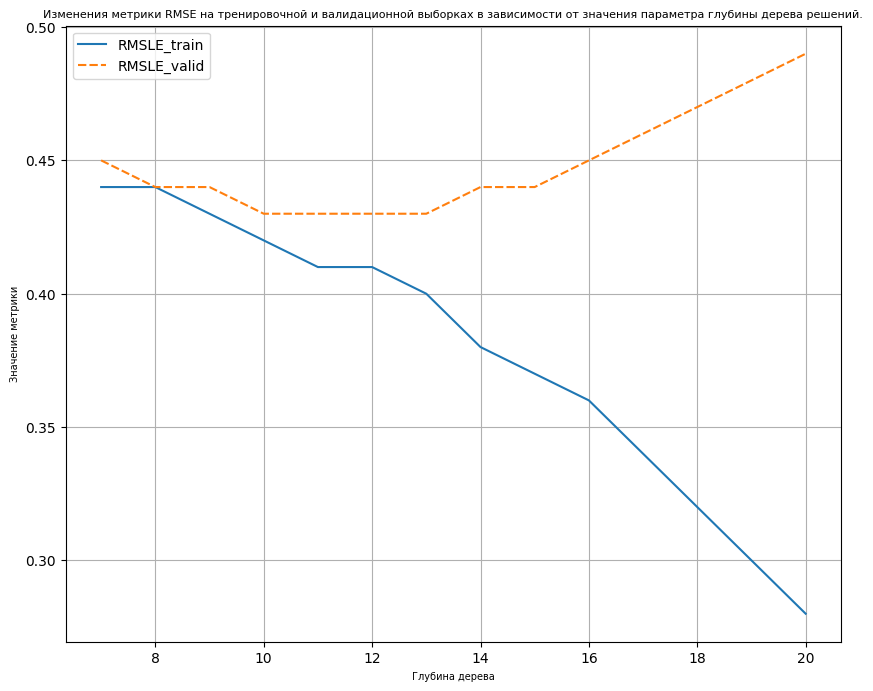

In [ ]:
RMSLE_train = []
RMSLE_valid = []
max_depth = range(7, 21)

for depth in max_depth:
  model = DecisionTreeRegressor(max_depth=depth, random_state = 42)
  model.fit(X_train, y_train_log)
  RMSLE_train.append(round(np.sqrt(metrics.mean_squared_error(y_train_log, model.predict(X_train))), 2))
  RMSLE_valid.append(round(np.sqrt(metrics.mean_squared_error(y_valid_log, model.predict(X_valid))), 2))

metrics_data = pd.DataFrame(data = {
        'RMSLE_train': RMSLE_train,
        'RMSLE_valid': RMSLE_valid
        },
                            index=range(7,21))
fig = plt.figure(figsize=(10,8))
plt.title('Изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.',
          fontsize=8)
plt.xlabel('Глубина дерева', fontsize=7)
plt.ylabel('Значение метрики', fontsize=7)
plt.grid()
sns.lineplot(metrics_data)

plt.show()

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь
rf = ensemble.RandomForestRegressor(n_estimators=200,
                                    max_depth=12,
                                    criterion='squared_error',
                                    min_samples_split=20,
                                    random_state=42)
rf.fit(X_train, y_train_log)

y_pred_train = rf.predict(X_train)
y_pred_valid = rf.predict(X_valid)

print('RMSLE on X_train: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))))
print('RMSLE on X_valid: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))))

RMSLE on X_train: 0.40
RMSLE on X_valid: 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь
gb = ensemble.GradientBoostingRegressor(
    learning_rate = 0.5,
    n_estimators = 100,
    max_depth = 6,
    min_samples_split = 30,
    random_state = 42
)

gb.fit(X_train, y_train_log)

y_pred_train = gb.predict(X_train)
y_pred_valid = gb.predict(X_valid)

print('RMSLE on X_train: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))))
print('RMSLE on X_valid: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))))

RMSLE on X_train: 0.37
RMSLE on X_valid: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


<Axes: >

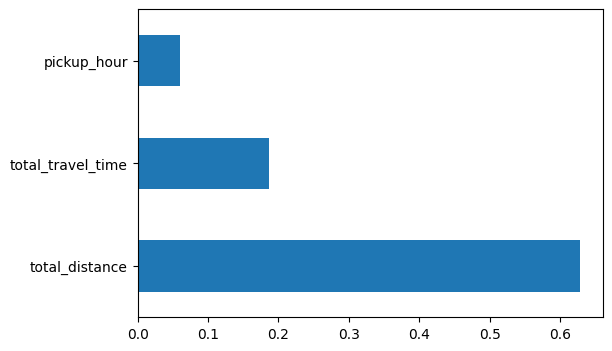

In [ ]:
plt.rcParams['figure.figsize'] = (6,4)
best_fea = pd.Series(gb.feature_importances_, index=X_train.columns)
best_fea.nlargest(3).plot(kind='barh')

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
y_valid = np.exp(y_valid_log)-1
y_pred = np.exp(y_pred_valid)-1
print('MeAE on X_valid: {:.1f}'.format(metrics.median_absolute_error(y_valid, y_pred)/60))

MeAE on X_valid: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
test_file = '/content/drive/MyDrive/Data_Science/Project_5_Задача_регрессии/test_data.csv'
osrm_data_test_file = '/content/drive/MyDrive/Data_Science/Project_5_Задача_регрессии/osrm_data_test.csv'

In [ ]:
test_data = pd.read_csv(test_file)
osrm_data_test = pd.read_csv(osrm_data_test_file)
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data, 'pickup_datetime')
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)

In [ ]:
X_test = test_data[best_features.index]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
y_test_predict = gb.predict(X_test_scaled)

In [ ]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_gb.csv', index=False)